In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta       
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10

Getting dataset from the files

In [119]:

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

def NormalizeData(X):
    X = X.astype('float64')
    X /= np.std(X, axis = 0)
    # X /=255
    return X
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train_unnormalized  =  X_train
X_test_unnormalized  =  X_test
X_train = NormalizeData(X_train)
X_test =  NormalizeData(X_test)
batches =  []
batches.append(unpickle("data_batch_1"))
batches.append(unpickle("data_batch_2"))
batches.append(unpickle("data_batch_3"))
batches.append(unpickle("data_batch_4"))
batches.append(unpickle("data_batch_5"))

features = []
labels = []
for batch in batches:
    features.append(np.array(batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)))
    labels.append(batch['labels'])
for feat in features:
    feat = NormalizeData(feat[:])
for lab in labels:
    maxval = np.max(lab)
    lab = np.eye(maxval+1)[lab]

In [120]:

def cost_derivative(aFunc, y):
    derivative = aFunc - y
    return derivative

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    return np.maximum(0,z)

def relu_derivative(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def tanh_derivative(z):
    return 1 - np.power(tanh(z), 2)

def softmax(x):
    e = np.exp(x-np.max(x))
    s = np.sum(e, axis=1, keepdims=True)
    return e/s   

def softmax_derivative(z):
    return softmax(z)*softmax(1-z)


def stringToFunc(stringAFunc, x):
    if (stringAFunc == "Relu"): return relu(x)
    elif (stringAFunc == "Leaky-ReLU"): return leaky_relu(x)
    elif (stringAFunc == "Sigmoid"): return sigmoid(x)
    elif (stringAFunc == "tanh"): return tanh(x)
    else: return softmax(x)

def stringToFuncDer(stringAFunc, x):
    if (stringAFunc == "Relu"): return relu_derivative(x)
    elif (stringAFunc == "Leaky-ReLU"): return leaky_relu_derivative(x)
    elif (stringAFunc == "Sigmoid"): return sigmoid_derivative(x)
    elif (stringAFunc == "tanh"): return tanh_derivative(x)
    else: return softmax_derivative(x)

def leaky_relu(x, alpha = 0.01):
    return np.maximum(alpha * x, x)

def leaky_relu_derivative(x, alpha = 0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx



Multilayer perceptron algorithm:

In [131]:
class MLP:
    
    def __init__(self, aFunc, numOfHiddenLayers, numOfHiddenUnits, dimension):
        self.aFunc = aFunc
        self.numOfHiddenLayers = numOfHiddenLayers
        self.numOfHiddenUnits = numOfHiddenUnits
        self.dimension = dimension
        self.weights = {}
        self.biases = {}

        for i in range(len(dimension)-1):
            self.weights[i + 1] = np.random.randn(dimension[i], dimension[i + 1])
            self.biases[i + 1] = np.zeros(dimension[i + 1])
            
        # i = 1
        # # Initialize weights and biases for hidden layers
        # for i in range(self.numOfHiddenLayers):
        #     self.weights[i + 1] = (np.random.randn(self.numOfHiddenUnits[i], self.numOfHiddenUnits[i-1]))
        #     self.biases[i + 1] = (np.zeros(self.numOfHiddenUnits[i]))
        
        # # Initialize weights and biases for output layer
        # self.weights[i + 1] = np.random.randn(10, self.numOfHiddenUnits[-1])
        # self.biases[i + 1] = np.zeros(10)
        
            
    def fit(self, x, y, optimizer):
        
        def backprop(self, Mlp, x, y):
            z = {}
            a = {1: x}  
            
            for i in range(1, Mlp.numOfHiddenLayers + 2):
                z[i + 1] = np.dot(a[i], Mlp.weights[i]) + Mlp.biases[i]
                a[i + 1] = stringToFunc(Mlp.aFunc[i-1], z[i + 1])
            last = len(a)
            delta = cost_derivative(a[last], y) * softmax_derivative(a[last]) 
            dw = np.dot(a[Mlp.numOfHiddenLayers + 1].T, delta)
        
            update_params = {
                 self.numOfHiddenLayers + 1: (dw, delta)
            }

            for i in reversed(range(2, Mlp.numOfHiddenLayers + 2)):
                dr = stringToFuncDer(Mlp.aFunc[i-2], z[i]) 
                delta = np.dot(delta, Mlp.weights[i].T) * dr
                dw = np.dot(a[i - 1].T, delta)
                update_params[i - 1] = (dw, delta)

            return update_params


        self = optimizer.run(self,backprop, x, y)
        return self
            
    def predict(self, x):
        z = {}
        a = {1: x}  
        
        for i in range(1, self.numOfHiddenLayers + 2):
            z[i + 1] = np.dot(a[i], self.weights[i]) + self.biases[i]
            a[i + 1] = stringToFunc(self.aFunc[i-1], z[i + 1])
        return np.argmax(a[self.numOfHiddenLayers+2],axis=1)

GradientDescent Algorithm

In [130]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, batch_size=16, max_iters=5, epsilon=1e-8, numOfHiddenLayers=0, lam = 0, regularization = None):
        self.numOfHiddenLayers = numOfHiddenLayers
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.lam = lam
        self.regularization = regularization
        
    def run(self, mlp,gradient_fn, x, y):
        m = x.shape
        num_batches = m[0] // self.batch_size
        norms = np.array([np.inf])
        t = 0
        while np.any(norms > self.epsilon) and t < self.max_iters:
            #permutation = np.random.permutation(len(x))
            x_shuffle = x#[permutation]
            y_shuffle = y#[permutation]
            
            for a in range(num_batches):
                start = a * self.batch_size
                end = start + self.batch_size
                x_batch = x_shuffle[start:end:]
                y_batch = y_shuffle[start:end:]

                # Compute the gradient 
                grad = gradient_fn(self,mlp,x_batch, y_batch)
                for k, v in grad.items():
                    dw = v[0]
                    if self.regularization == "l1":
                        dw += (self.lam) * mlp.weights[k] 
                    elif self.regularization == "l2":
                        dw += (self.lam) * np.sign(mlp.weights[k])
                    mlp.weights[k] -= self.learning_rate * dw
                    mlp.biases[k] -= self.learning_rate * np.mean(v[1], 0)
                # for p in range(len(params)):
                #     params[p] -= self.learning_rate * grad[p]
                # norms = np.array([np.linalg.norm(g) for g in grad])
            t += 1
        return mlp

Experiment 1: 
First of all, create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs
to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2
hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform
classification, all of these models should have a softmax layer at the end. After training, compare the test
accuracy of these three models on the CIFAR-10 dataset. Comment on how non-linearity and network depth
affects the accuracy. Are the results that you obtain expected?

In [123]:
#no hidden layers
no_hidden = MLP(("softmax", ),0,(0,), (3072,10))
optimizer = GradientDescent(numOfHiddenLayers=0)
fit_no_hidden = no_hidden.fit(X_train,y_train, optimizer)
no_hidden_yh = fit_no_hidden.predict(X_test)
#one layer
optimizer = GradientDescent(numOfHiddenLayers=1)
single_layer=  MLP(("relu", "softmax"),1,(256,),(3072,256,10))
fit_single_layer = single_layer.fit(X_train,y_train, optimizer)
single_yh = fit_single_layer.predict(X_test)
#two layers
optimizer = GradientDescent(numOfHiddenLayers=2)
two_layers = MLP(("relu", "relu", "softmax"),2,(256,256),(3072,256,256,10))
fit_two_layers = two_layers.fit(X_train,y_train, optimizer)
two_yh = fit_two_layers.predict(X_test)
def evaluate_acc (True_label,Predicted_label):
    return np.sum(True_label == Predicted_label)/Predicted_label.shape[0]
print("Accuracy on test data no layer", evaluate_acc(y_test,no_hidden_yh.reshape(10000,1)))
print("Accuracy on test data one layer", evaluate_acc(y_test,single_yh.reshape(10000,1)))
print("Accuracy on test data two layer", evaluate_acc(y_test,two_yh.reshape(10000,1)))

/var/folders/b5/ct06m_093mj2jmq58ft3jbq00000gn/T/ipykernel_76493/605528332.py:28: RuntimeWarning: invalid value encountered in divide
  return e/s


Accuracy on test data no layer 0.1
Accuracy on test data one layer 0.1082
Accuracy on test data two layer 0.1036


Experiment 2:
 Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the
activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with
model having ReLU activations. Comment on the performances of these models: which one is better and why?
Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [124]:
optimizer = GradientDescent(numOfHiddenLayers=2)
#TANH
two_tanh = MLP(("tanh", "tanh", "softmax"),2,(256,256),(3072,256,256,10))
fit_two_tanh = two_tanh.fit(X_train,y_train, optimizer)
two_tanh_yh = fit_two_tanh.predict(X_test)
#Leaky-Relu
two_lrelu= MLP(("Leaky-ReLU", "Leaky-ReLU", "softmax"),2,(256,256),(3072,256,256,10))
fit_two_lrelu = two_lrelu.fit(X_train,y_train, optimizer)
two_lrelu_yh = fit_two_lrelu.predict(X_test)
print("Accuracy on test data tanh", evaluate_acc(y_test,two_lrelu_yh.reshape(10000,1)))
print("Accuracy on test dataleaky-relu", evaluate_acc(y_test,two_tanh_yh.reshape(10000,1)))

/var/folders/b5/ct06m_093mj2jmq58ft3jbq00000gn/T/ipykernel_76493/605528332.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
/var/folders/b5/ct06m_093mj2jmq58ft3jbq00000gn/T/ipykernel_76493/605528332.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
/var/folders/b5/ct06m_093mj2jmq58ft3jbq00000gn/T/ipykernel_76493/605528332.py:28: RuntimeWarning: invalid value encountered in divide
  return e/s


Accuracy on test data tanh 0.1
Accuracy on test dataleaky-relu 0.1


Experiment 3:
Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this
time, independently add L1 and L2 regularization to the network and train the MLP in this way. How does
these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be
explored as part of other project requirements.

In [132]:
#L1 regularization
optimizer = GradientDescent(numOfHiddenLayers=2, lam = 0.3, regularization="l1")
two_layers = MLP(("relu", "relu", "softmax"),2,(256,256),(3072,256,256,10))
fit_two_layers = two_layers.fit(X_train,y_train, optimizer)
yh_l1 = fit_two_layers.predict(X_test)

#L2 Regularization
optimizer = GradientDescent(numOfHiddenLayers=2, lam = 0.3, regularization="l2")
two_layers = MLP(("relu", "relu", "softmax"),2,(256,256),(3072,256,256,10))
fit_two_layers = two_layers.fit(X_train,y_train, optimizer)
yh_l2 = fit_two_layers.predict(X_test)
print("Accuracy on test data reg L1", evaluate_acc(y_test,yh_l1.reshape(10000,1)))
print("Accuracy on test data reg L2", evaluate_acc(y_test,yh_l2.reshape(10000,1)))

Accuracy on test data reg L1 0.1
Accuracy on test data reg L2 0.1


Experiment 4:
Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
train it with unnormalized images. How does this affect the accuracy?

In [126]:
optimizer_u = GradientDescent(numOfHiddenLayers=2)
two_layers_u = MLP(("relu", "relu", "softmax"),2,(256,256),(3072,256,256,10))
two_relu_u = two_layers_u.fit(X_train_unnormalized,y_train, optimizer_u)
two_relu_u_yh = two_relu_u.predict(X_test_unnormalized)
print("Accuracy on test data one layer", evaluate_acc(y_test,two_relu_u_yh.reshape(10000,1)))

/var/folders/b5/ct06m_093mj2jmq58ft3jbq00000gn/T/ipykernel_76493/605528332.py:28: RuntimeWarning: invalid value encountered in divide
  return e/s


Accuracy on test data one layer 0.1


Experiment 5:
Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2
convolutional and 2 fully connected layers. Although you are free in your choice of the hyperparameters of the
convolutional layers, set the number of units in the fully connected layers to be 256. Also, set the activations in
all of the layers to be ReLU. Train this CNN on the CIFAR-10 dataset. Does using a CNN increase/decrease the
accuracy compared to using MLPs? Provide comments on your results.

In [127]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10

# Define the hyperparameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Define the CNN
cnn_model = keras.Sequential(
    [
        layers.Conv2D(16, (5, 5), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, (5, 5), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10),
    ]
)

# Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Train the model
cnn_history  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)


Epoch 1/5
500/500 [==============================] - 55s 107ms/step - loss: 1.5061 - accuracy: 0.4523 - val_loss: 1.2402 - val_accuracy: 0.5513
Epoch 2/5
500/500 [==============================] - 56s 111ms/step - loss: 1.1259 - accuracy: 0.5997 - val_loss: 1.0796 - val_accuracy: 0.6141
Epoch 3/5
500/500 [==============================] - 49s 99ms/step - loss: 0.9695 - accuracy: 0.6581 - val_loss: 0.9931 - val_accuracy: 0.6479
Epoch 4/5
500/500 [==============================] - 46s 92ms/step - loss: 0.8504 - accuracy: 0.7018 - val_loss: 0.9400 - val_accuracy: 0.6715
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.9060 - accuracy: 0.6860
Test accuracy: 0.6859999895095825


Experiment 6:
Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch,
and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully
connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the
pre-trained model on the CIFAR-10 dataset. How does this pre-trained model compare to the best MLP in part
1 and to the regular CNN in part 5 in terms of the accuracy? How does it compare to the previous models in
terms of the required training time? Justify your choice of how many fully connected layers that you have added
to the pre-trained model through careful experiments.

In [133]:
import tensorflow as tf
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications import ResNet50

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Load the pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(32, 32, 3))

# Freeze all the convolutional layers
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False

# Remove all the fully connected layers
x = Flatten()(base_model.output)

# Add your own fully connected layers
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(10, activation="softmax")(x)

# Create a new model with your own fully connected layers
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train only the fully connected layers of the pre-trained model
pretrained_history = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_test, y_test))
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 [==============================] - 28s 90ms/step - loss: 1.2662 - accuracy: 0.5609
Test accuracy: 0.5608999729156494


Experiment 7:
You can report your findings either in the form of a table or a plot in the write-up. However, include in your
colab notebooks the plots of the test and train performance of the MLPs / CNN / pre-trained model as a function
of training epochs. This will allow you to see how much the network should be trained before it starts to overfit
to the training data.

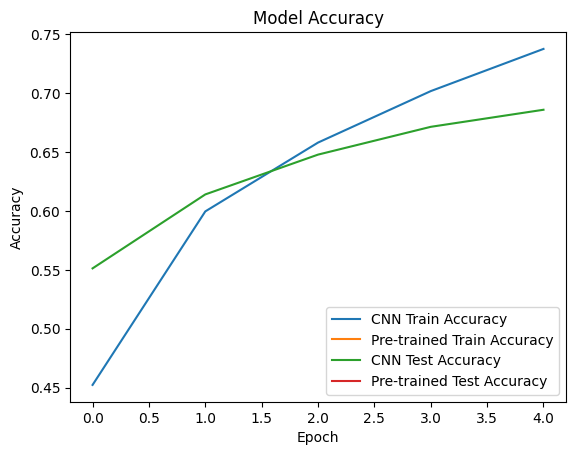

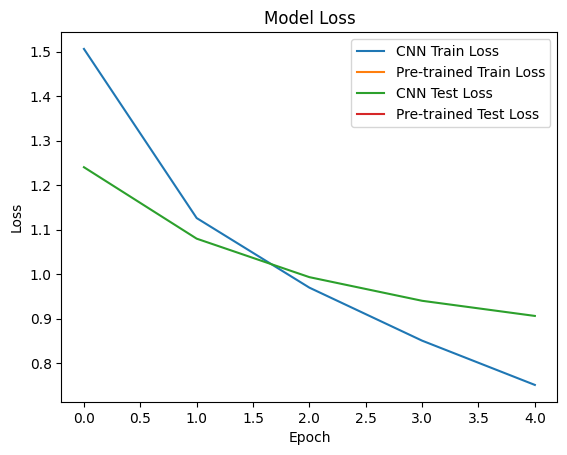

In [134]:
# Plot the train and test accuracy of the CNN and pre-trained models
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(pretrained_history.history['accuracy'], label='Pre-trained Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Test Accuracy')
plt.plot(pretrained_history.history['val_accuracy'], label='Pre-trained Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot the train and test loss of the CNN and pre-trained models
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(pretrained_history.history['loss'], label='Pre-trained Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Test Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pre-trained Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Extra test 1:
Changing number of units in the hidden layer.
First example has 128 units and second has 512. They both use Relu and two layers

In [135]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = NormalizeData(X_train)
X_test =  NormalizeData(X_test)
optimizer = GradientDescent(numOfHiddenLayers=2)
#128 units
mlp_128 = MLP(("relu", "relu", "softmax"),2,(128,128),(3072,128,128,10))
fit_mlp_128 = mlp_128.fit(X_train,y_train, optimizer)
mlp_128_yh = fit_mlp_128.predict(X_test)
#512 units
mlp_512 = MLP(("relu", "relu", "softmax"),2,(512,512),(3072,512,512,10))
fit_mlp_512 = mlp_512.fit(X_train,y_train, optimizer)
mlp_512_yh = fit_mlp_512.predict(X_test)
print("Accuracy on test data 128 units", evaluate_acc(y_test,mlp_128_yh.reshape(10000,1)))
print("Accuracy on test data 512 units", evaluate_acc(y_test,mlp_512_yh.reshape(10000,1)))
print("Accuracy on test data 256 units", evaluate_acc(y_test,mlp_128_yh.reshape(10000,1)))


/var/folders/b5/ct06m_093mj2jmq58ft3jbq00000gn/T/ipykernel_76493/605528332.py:28: RuntimeWarning: invalid value encountered in divide
  return e/s


Accuracy on test data 128 units 0.1001
Accuracy on test data 512 units 0.1
Accuracy on test data 256 units 0.1001
